# Codon Usage Bias Analysis Across Species

## Introduction and Setup

**Codon usage bias** refers to the phenomenon where synonymous codons (codons encoding the same amino acid) are used with different frequencies. This bias varies across:
- Different species
- Different genes within the same organism
- Highly vs. lowly expressed genes

Why is this important?
1. Gene expression optimization
2. Heterologous protein expression
3. Evolutionary analysis
4. Gene origin prediction
5. Synthetic biology application

In [40]:
# Library
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# BioPython
from Bio import SeqIO

In [41]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## Codons

### Codon Table

In [42]:
# Standard genetic code (codon to amino acid mapping)
CODON_TABLE = {
    'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L',
    'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S',
    'TAT': 'Y', 'TAC': 'Y', 'TAA': '*', 'TAG': '*',
    'TGT': 'C', 'TGC': 'C', 'TGA': '*', 'TGG': 'W',
    'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
    'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
    'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
    'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',
    'ATT': 'I', 'ATC': 'I', 'ATA': 'I', 'ATG': 'M',
    'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
    'AAT': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K',
    'AGT': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R',
    'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
    'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
    'GAT': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
    'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'
}

In [43]:
from collections import defaultdict

# Group codons by amino acids
def get_synonymous_codons():
    """Return dictionary of amino acids and their synonymous codons"""
    aa_codons = defaultdict(list)
    for codon, aa in CODON_TABLE.items():
        if aa != '*':       # Exclude stop codons
            aa_codons[aa].append(codon)
    return dict(aa_codons)

In [44]:
SYNONYMOUS_CODONS = get_synonymous_codons()
SYNONYMOUS_CODONS

{'F': ['TTT', 'TTC'],
 'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'],
 'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'],
 'Y': ['TAT', 'TAC'],
 'C': ['TGT', 'TGC'],
 'W': ['TGG'],
 'P': ['CCT', 'CCC', 'CCA', 'CCG'],
 'H': ['CAT', 'CAC'],
 'Q': ['CAA', 'CAG'],
 'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],
 'I': ['ATT', 'ATC', 'ATA'],
 'M': ['ATG'],
 'T': ['ACT', 'ACC', 'ACA', 'ACG'],
 'N': ['AAT', 'AAC'],
 'K': ['AAA', 'AAG'],
 'V': ['GTT', 'GTC', 'GTA', 'GTG'],
 'A': ['GCT', 'GCC', 'GCA', 'GCG'],
 'D': ['GAT', 'GAC'],
 'E': ['GAA', 'GAG'],
 'G': ['GGT', 'GGC', 'GGA', 'GGG']}

### Count Codons

In [45]:
from collections import Counter

# Codon Counting Function
def count_codons(sequence):
    """Count codon frequencies in a DNA sequence"""
    sequence = sequence.upper().replace('U', 'T')

    # Ensure sequence length is divisible by 3
    if len(sequence) % 3 != 0:
        sequence = sequence[:(len(sequence) % 3)]

    # Collect the codons
    codons = [sequence[i:i+3] for i in range(0, len(sequence), 3)]

    # Filter valid codons
    valid_codons = [c for c in codons if c in CODON_TABLE and CODON_TABLE[c] != '*']

    return Counter(valid_codons)


### Calculate Relative Synonymous Codon Usage (RSCU)

In [46]:
def calculate_rscu(codon_counts):
    """
    Calculate Relative Synonymous Codon Usage (RSCU)

    RSCU = (observed frequency of codon) / (expected frequency if all synonymous codon used equally)
    RSCU = 1 means no bias
    RSCU > 1.0 means codon is used more than expected
    RSCU < 1.0 means codon is used less than expected

    Parameters:
    -----------
    codon_counts: Counter
        Codon Frequencies

    Returns:
    --------
    dict: RSCU values for each codon
    """
    rscu_values = {}

    for aa, codons in SYNONYMOUS_CODONS.items():
        # Count total usage of all synonymous codons for this amino acid
        total_aa_count = sum(codon_counts.get(codon, 0) for codon in codons)

        if total_aa_count == 0:
            continue

        # Calculate RSCU for each synonymous codon
        num_synonymous = len(codons)
        for codon in codons:
            observed = codon_counts.get(codon, 0)
            expected = total_aa_count / num_synonymous
            rscu_values[codon] = (observed / expected) if expected > 0 else 0

    return rscu_values

### Calculate Effective Number of Codons (ENC)

In [47]:
def calculate_enc(codon_counts):
    """
    Calculate Effective Number of Codons (ENC)

    ENC measures the overall codon usage bias in a gene
    Range: 20 (maximum bias) to 61 (no bias)

    Parameters:
    -----------
    codon_counts: Counter
        Codon Frequencies

    Returns:
    --------
    float: ENC Value
    """
    
    # Group amino acids by degeneracy
    two_fold = ['D', 'E', 'F', 'H', 'K', 'N', 'Q', 'Y', 'C']
    three_fold = ['I']
    four_fold = ['A', 'G', 'P', 'T', 'V']
    six_fold = ['L', 'R', 'S']

    def homozygosity(codons, codon_counts):
        """Calculate homozygosity for a group of synonymous codons"""
        total = sum(codon_counts.get(c, 0) for c in codons)
        if total == 0:
            return 0
        return sum((codon_counts.get(c, 0) / total) ** 2 for c in codons)

    # Calculate F values for each degeneracy class
    F2 = np.mean([homozygosity(SYNONYMOUS_CODONS[aa], codon_counts) for aa in two_fold if aa in SYNONYMOUS_CODONS])
    F3 = np.mean([homozygosity(SYNONYMOUS_CODONS['I'], codon_counts)])
    F4 = np.mean([homozygosity(SYNONYMOUS_CODONS[aa], codon_counts) for aa in four_fold if aa in SYNONYMOUS_CODONS])
    F6 = np.mean([homozygosity(SYNONYMOUS_CODONS[aa], codon_counts) for aa in six_fold if aa in SYNONYMOUS_CODONS])

    # Calculate ENC
    enc = 2 + 9/F2 + 1/F3 + 5/F4 + 3/F6 if all([F2, F3, F4, F6]) else 61

    return min(enc, 61) # Cap at 61

### Calculate Codon Adaptation Index (CAI)

In [48]:
def calculate_cai(codon_counts, reference_counts):
    """
    Calculate Codon Adaptation Index (CAI)

    CAI measures how similar a gene's codon usage is to highly expressed genes
    Range: 0 to 1 (higher = more similar to reference set)

    Parameters:
    -----------
    codon_counts: Counter
        Codon Frequencies in Gene
    reference_counts: Counter
        Codon Frequencies in reference set

    Returns:
    --------
    float: CAI Value
    """

    # Calculate relative adaptiveness (w) for each codon
    w_values = {}
    for aa, codons in SYNONYMOUS_CODONS.items():
        max_usage = max(reference_counts.get(c, 0) for c in codons)
        if max_usage == 0:
            continue
        for codon in codons:
            w_values[codon] = reference_counts.get(codon, 0) / max_usage

    # Calculate geometric mean of w values
    w_products = []
    for codon, count in codon_counts.items():
        if codon in w_values and count > 0:
            w_products.extend([w_values[codon]] * count)

    if not w_products:
        return 0
    
    cai = np.exp(np.mean(np.log(np.array(w_products) + 1e-10)))
    return cai

## Multi-Species Analysis

In [67]:
class CodonUsageAnalyzer:
    """Comprehensive codon usage analysis for multiple species"""

    def __init__(self):
        self.species_data = {}

    def add_species(self, species_name, sequences):
        """Add species data for analysis"""
        # Aggregate codon counts across all sequences
        total_counts = Counter()
        enc_values = []

        for seq in sequences:
            counts = count_codons(seq)
            total_counts.update(counts)
            enc_values.append(calculate_enc(counts))

        # Calculate RSCU
        rscu = calculate_rscu(total_counts)

        self.species_data[species_name] = {
            'codon_counts': total_counts,
            'rscu': rscu,
            'enc_mean': np.mean(enc_values),
            'enc_std': np.std(enc_values),
            'num_sequences': len(sequences)
        }

    def compare_species(self):
        """Create comparison dataframe for all species"""
        if not self.species_data:
            print("No species data available")
            return None
        
        comparison_data = []

        for species, data in self.species_data.items():
            for codon, rscu_value in data['rscu'].items():
                comparison_data.append({
                    'Species': species,
                    'Codon': codon,
                    'Amino_Acid': CODON_TABLE[codon],
                    'RSCU': rscu_value,
                    'Count': data['codon_counts'][codon]
                })

        return pd.DataFrame(comparison_data)
    
    def plot_rscu_heatmap(self, amino_acid=None):
        """Plot RSCU heatmap across species"""
        df = self.compare_species()
        if df is None:
            return

        if amino_acid:
            df = df[df['Amino_Acid'] == amino_acid]
            title = f'RSCU Heatmap for {amino_acid} Codons'
        else:
            title = 'RSCU Heatmap - All Codons'

        # Pivot for heatmap
        pivot_df = df.pivot(index='Codon', columns='Species', values='RSCU')

        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot_df, annot=True, fmt='.2f', cmap='RdYlGn', center=1.0, vmin=0, vmax=2, cbar_kws={'label': 'RSCU'})
        plt.title(title, fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

    def plot_enc_comparison(self):
        """Plot ENC distribution comparison across species"""
        species_names = list(self.species_data.keys())
        enc_means = [self.species_data[s]['enc_mean'] for s in species_names]
        enc_stds = [self.species_data[s]['enc_std'] for s in species_names]

        plt.figure(figsize=(10, 6))
        plt.bar(species_names, enc_means, yerr=enc_stds, capsize=10, alpha=0.7, edgecolor='black')
        plt.axhline(y=61, color='r', linestyle='--', label='No bias (ENC = 61)')
        plt.axhline(y=20, color='b', linestyle='--', label='Maximum Bias (ENC = 20)')
        plt.ylabel('Effective Number of Codons (ENC)', fontsize=12)
        plt.xlabel('Species', fontsize=12)
        plt.title('Codon Usage Bias Comparison (ENC)', fontsize=14, fontweight='bold')
        plt.legend()
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def calculate_gc_content(self):
        """Calculate GC content at different codon positions"""
        gc_data = []

        for species, data in self.species_data.items():
            gc1, gc2, gc3 = 0, 0, 0
            total = 0

            for codon, count in data['codon_counts'].items():
                gc1 += count if codon[0] in 'GC' else 0
                gc2 += count if codon[1] in 'GC' else 0
                gc3 += count if codon[2] in 'GC' else 0
                total += count

            if total > 0:
                gc_data.append({
                    'Species': species,
                    'GC1': gc1 / total,
                    'GC2': gc2 / total,
                    'GC3': gc3 / total,
                    'GC_total': (gc1 + gc2 + gc3) / (3 * total)
                })

        return pd.DataFrame(gc_data)
    
    def plot_gc_content(self, figsize=(12, 6)):
        """
        Plot GC content at codon positions
        """
        gc_df = self.calculate_gc_content()
        
        x = np.arange(len(gc_df))
        width = 0.2
        
        fig, ax = plt.subplots(figsize=figsize)
        
        bars1 = ax.bar(x - 1.5*width, gc_df['GC1'], width, label='GC1', color='#3498db')
        bars2 = ax.bar(x - 0.5*width, gc_df['GC2'], width, label='GC2', color='#2ecc71')
        bars3 = ax.bar(x + 0.5*width, gc_df['GC3'], width, label='GC3', color='#e74c3c')
        bars4 = ax.bar(x + 1.5*width, gc_df['GC_total'], width, label='GC Total', color='#95a5a6')
        
        ax.set_ylabel('GC Content (%)', fontsize=13, fontweight='bold')
        ax.set_xlabel('Species', fontsize=13, fontweight='bold')
        ax.set_title('GC Content at Codon Positions', fontsize=16, fontweight='bold', pad=20)
        ax.set_xticks(x)
        ax.set_xticklabels(gc_df['Species'], rotation=45, ha='right')
        ax.legend(fontsize=11)
        ax.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return gc_df

    def get_most_biased_codons(self, n=10):
        """
        Get most biased codons for each species
        
        Parameters:
        -----------
        n : int
            Number of top biased codons to return
        
        Returns:
        --------
        dict : Dictionary of species -> biased codons
        """
        biased_codons = {}
        
        for species, data in self.species_data.items():
            # Calculate deviation from RSCU = 1.0
            codon_bias = [(codon, abs(rscu - 1.0), rscu) 
                          for codon, rscu in data['rscu'].items()]
            # Sort by bias magnitude
            codon_bias.sort(key=lambda x: x[1], reverse=True)
            biased_codons[species] = codon_bias[:n]
        
        return biased_codons
    
    def print_summary(self):
        """
        Print comprehensive summary of analysis
        """
        print("\n" + "=" * 70)
        print("CODON USAGE ANALYSIS SUMMARY")
        print("=" * 70)
        
        for species, data in self.species_data.items():
            print(f"\n{species}:")
            print(f"  Sequences analyzed: {data['num_sequences']}")
            print(f"  Total codons counted: {sum(data['codon_counts'].values())}")
            print(f"  ENC: {data['enc_mean']:.2f} ± {data['enc_std']:.2f}")
            
            # GC content
            gc1, gc2, gc3, total = 0, 0, 0, 0
            for codon, count in data['codon_counts'].items():
                if codon[0] in 'GC': gc1 += count
                if codon[1] in 'GC': gc2 += count
                if codon[2] in 'GC': gc3 += count
                total += count
            
            if total > 0:
                print(f"  GC Content: {(gc1+gc2+gc3)/(3*total)*100:.1f}% "
                      f"(GC3: {gc3/total*100:.1f}%)")
            
            # Most biased codons
            biased = [(c, abs(r-1), r) for c, r in data['rscu'].items()]
            biased.sort(key=lambda x: x[1], reverse=True)
            print(f"  Most biased codon: {biased[0][0]} "
                  f"({CODON_TABLE[biased[0][0]]}) - RSCU: {biased[0][2]:.2f}")


### Generate Sample Sequences

In [50]:
def generate_sample_sequences(gc_bias=0.5, num_seqs=100, length=300):
    """
    Generate sample coding sequences for demonstration
    
    Parameters:
    -----------
    gc_bias: float
        GC content bias (0 to 1)
    num_seqs: int
        Number of sequences to generate
    length: int
        Length of each sequence (must be divisible by 3)
    """

    sequences = []
    codons = [c for c in CODON_TABLE.keys() if CODON_TABLE[c] != '*']

    # Weight codons by GC content
    weights = []
    for codon in codons:
        gc_count = codon.count('G') + codon.count('C')
        weight = gc_bias * gc_count + (1 - gc_bias) * (3 - gc_count)
        weights.append(weight)

    weights = np.array(weights) / sum(weights)

    for _ in range(num_seqs):
        seq_codons = np.random.choice(codons, size=length//3, p=weights)
        sequences.append(''.join(seq_codons))

    return sequences

In [51]:
analyzer = CodonUsageAnalyzer()

In [52]:
# Add sample data for three "species" with different biases
analyzer.add_species("High GC Organism", generate_sample_sequences(gc_bias=0.7, num_seqs=100))
analyzer.add_species("Neutral Organism", generate_sample_sequences(gc_bias=0.5, num_seqs=100))
analyzer.add_species("Low GC Organism", generate_sample_sequences(gc_bias=0.3, num_seqs=100))

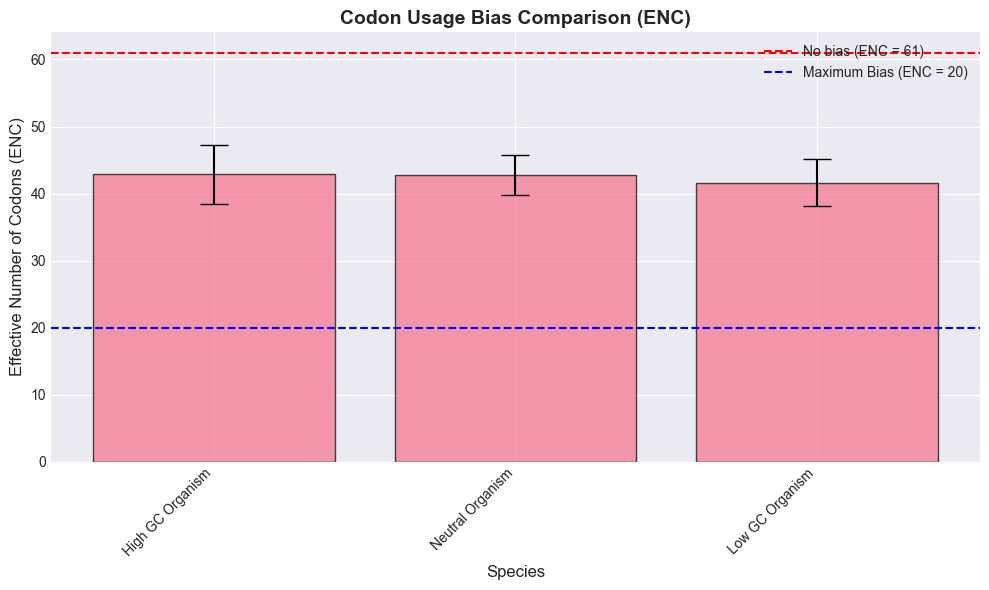

In [53]:
analyzer.plot_enc_comparison()

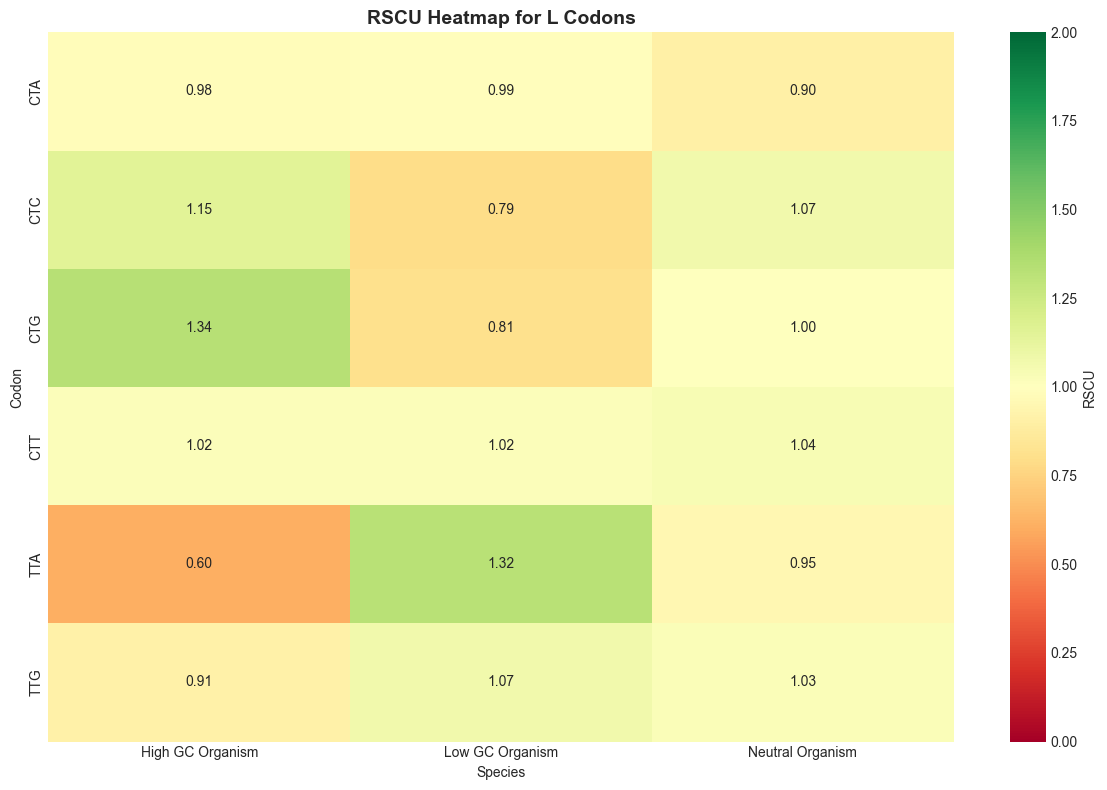

In [54]:
analyzer.plot_rscu_heatmap(amino_acid='L')

In [57]:
gc_df = analyzer.calculate_gc_content()
gc_df

,Species,GC1,GC2,GC3,GC_total
0,High GC Organism,0.5882,0.5787,0.5816,0.582833
1,Neutral Organism,0.5328,0.5148,0.5021,0.516567
2,Low GC Organism,0.4533,0.4451,0.4410,0.446467


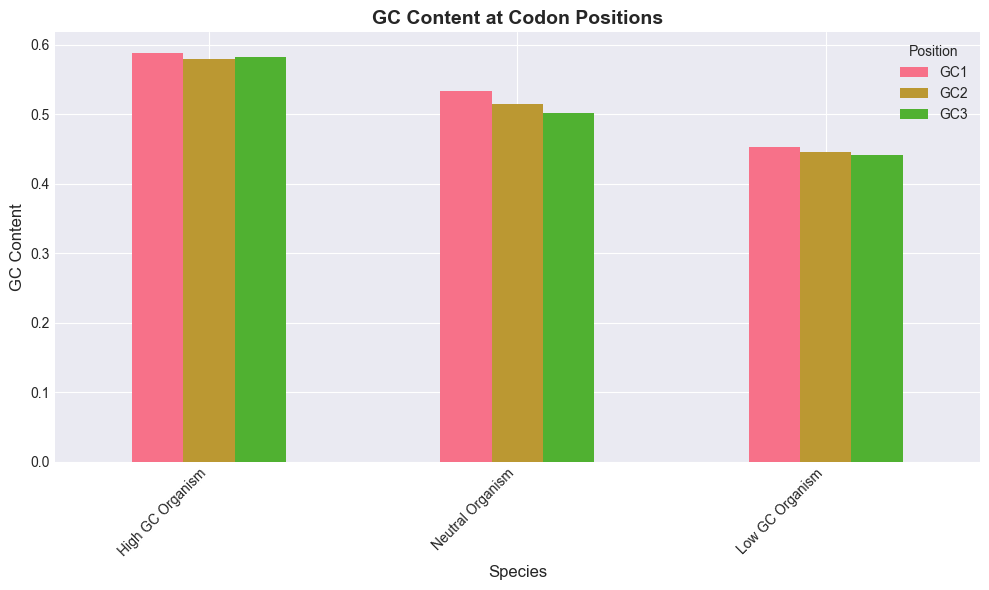

In [59]:
gc_plot = gc_df.set_index('Species')[['GC1', 'GC2', 'GC3']]
gc_plot.plot(kind='bar', figsize=(10, 6))
plt.ylabel('GC Content', fontsize=12)
plt.xlabel('Species', fontsize=12)
plt.title('GC Content at Codon Positions', fontsize=14, fontweight='bold')
plt.legend(title='Position')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [62]:
comparison_df = analyzer.compare_species()
for species in analyzer.species_data.keys():
    if comparison_df is None:
        continue
    species_df = comparison_df[comparison_df['Species'] == species]
    # Find codons with highest deviation from RSCU = 1.0
    species_df['Bias'] = abs(species_df['RSCU'] - 1.0)
    top_biased = species_df.nlargest(10, 'Bias')[['Codon', 'Amino_Acid', 'RSCU', 'Count']]
    print(f"\n{species}:")
    print(top_biased.to_string(index=False))



High GC Organism:
Codon Amino_Acid     RSCU  Count
  TTA          L 0.604651     91
  CTG          L 1.335548    201
  CAT          H 0.685535    109
  CAC          H 1.314465    209
  ACC          T 1.296124    209
  ACA          T 0.713178    115
  AGA          R 0.756986    149
  CGC          R 1.239627    244
  TCC          S 1.235656    201
  ATC          I 1.234783    142

Neutral Organism:
Codon Amino_Acid     RSCU  Count
  ATA          I 1.135667    173
  TCT          S 1.117330    173
  GTC          V 0.888252    155
  CAT          H 1.107383    165
  CAC          H 0.892617    133
  CGG          R 0.896414    150
  CTA          L 0.898492    149
  GTG          V 1.094556    191
  CCC          P 1.088191    182
  CCG          P 0.914798    153

Low GC Organism:
Codon Amino_Acid     RSCU  Count
  AGA          R 1.402693    191
  CCT          P 1.354839    168
  CGG          R 0.660955     90
  CGC          R 0.675643     92
  TTA          L 1.320652    243
  GGT          G 1.2

C:\Users\shres\AppData\Local\Temp\ipykernel_91720\552042065.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  species_df['Bias'] = abs(species_df['RSCU'] - 1.0)
C:\Users\shres\AppData\Local\Temp\ipykernel_91720\552042065.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  species_df['Bias'] = abs(species_df['RSCU'] - 1.0)
C:\Users\shres\AppData\Local\Temp\ipykernel_91720\552042065.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c